In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import os
import pickle
import lzma
import typing
from metadrive import MetaDriveEnv
from concurrent.futures import ProcessPoolExecutor
from env import State, Observation, Action, next_state, normalize_angle, get_metadrive_state, obs_batch_to_tensor, state_batch_to_tensor, action_batch_to_tensor
from metadrive_model import MetadriveModel, metadrive_model_train_batch
from model_utils import set_lr, deviceof
from torch.utils.data import TensorDataset, DataLoader
import itertools

In [3]:
with lzma.open("./data/mm_data.pkl.xz", "rb") as f:
    mm_data: list[tuple[State, Action, State]] = pickle.load(f)

In [4]:
# 90:10 train-validation split
random.seed(0)
random.shuffle(mm_data)
mm_train_data = mm_data[:int(len(mm_data)*0.9)]
mm_validation_data = mm_data[int(len(mm_data)*0.9):]

In [5]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 768, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc3 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx4x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = F.relu(self.fc2(x)) # Bx768 -> Bx768
        x = self.fc3(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_tensor: torch.Tensor,
        a_tensor: torch.Tensor,
) -> float:
    device = deviceof(idm)

    obs_tensor = obs_tensor.to(device)
    a_tensor = a_tensor.to(device)

    idm_optimizer.zero_grad()

    loss = F.mse_loss(idm(obs_tensor), a_tensor)

    loss.backward()

    idm_optimizer.step()

    return float(loss.item())
    

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor([(s0, s1) for s0, _, s1 in mm_train_data], torch.device("cpu")),
    action_batch_to_tensor([a for _, a, _ in mm_train_data], torch.device("cpu")),
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [34]:
set_lr(idm_optimizer, 1e-4)
IDM_TRAIN_EPOCHS = 500_000

while idm_step < IDM_TRAIN_EPOCHS:
    # take up to n from the data buffer
    obs_batch, a_batch = next(idm_train_iter)

    # train
    loss = idm_train_batch(idm, idm_optimizer, obs_batch, a_batch)
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 1000 == 0:
        # print average loss over the last 1000 steps
        loss = np.mean(idm_losses[-1000:])
        print(f"Step: {idm_step}, Loss: {loss:.4f}")

Step: 21000, Loss: 0.0225
Step: 22000, Loss: 0.0221
Step: 23000, Loss: 0.0218
Step: 24000, Loss: 0.0215
Step: 25000, Loss: 0.0211
Step: 26000, Loss: 0.0208
Step: 27000, Loss: 0.0205
Step: 28000, Loss: 0.0202
Step: 29000, Loss: 0.0199
Step: 30000, Loss: 0.0196
Step: 31000, Loss: 0.0194
Step: 32000, Loss: 0.0191
Step: 33000, Loss: 0.0188
Step: 34000, Loss: 0.0187
Step: 35000, Loss: 0.0183
Step: 36000, Loss: 0.0182
Step: 37000, Loss: 0.0179
Step: 38000, Loss: 0.0177
Step: 39000, Loss: 0.0175
Step: 40000, Loss: 0.0173
Step: 41000, Loss: 0.0171
Step: 42000, Loss: 0.0169
Step: 43000, Loss: 0.0167


KeyboardInterrupt: 

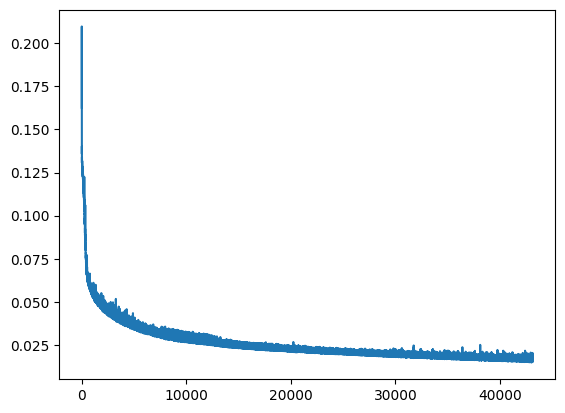

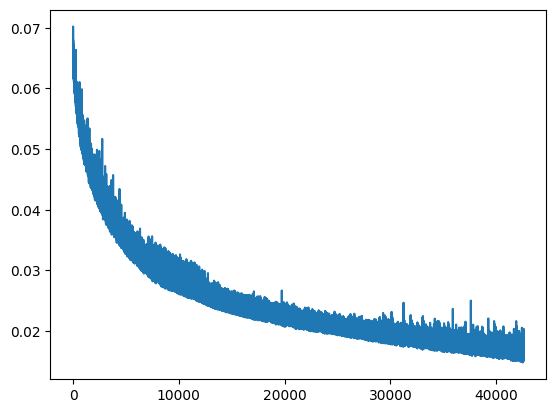

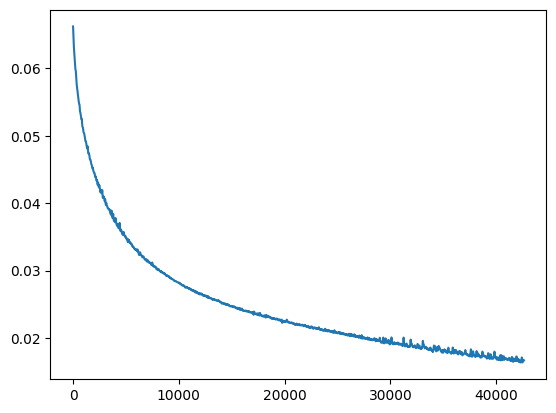

In [35]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses)
plt.show()

latter_training = idm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training)
plt.show()

# denoise
latter_training_denoised = gaussian_filter1d(latter_training, sigma=20)
plt.plot(list(range(len(latter_training_denoised))), latter_training_denoised)
plt.show()

In [36]:
obs_tensor = obs_batch_to_tensor([(s0, s1) for s0, _, s1 in mm_train_data], device)
a_tensor = action_batch_to_tensor([a for _, a, _ in mm_train_data], device)

with torch.no_grad():
    a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.017207002267241478


In [37]:
obs_tensor = obs_batch_to_tensor([(s0, s1) for s0, _, s1 in mm_validation_data], device)
a_tensor = action_batch_to_tensor([a for _, a, _ in mm_validation_data], device)

with torch.no_grad():
    a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.017548715695738792


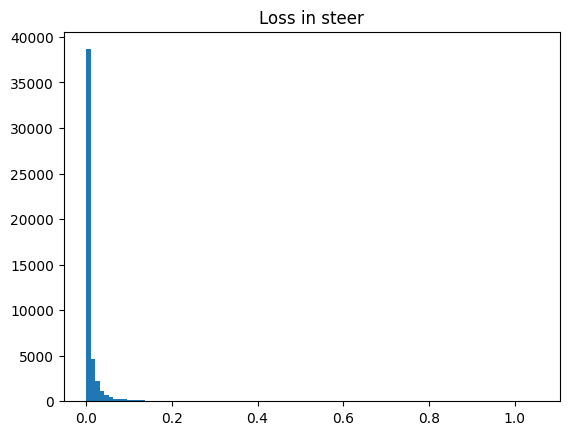

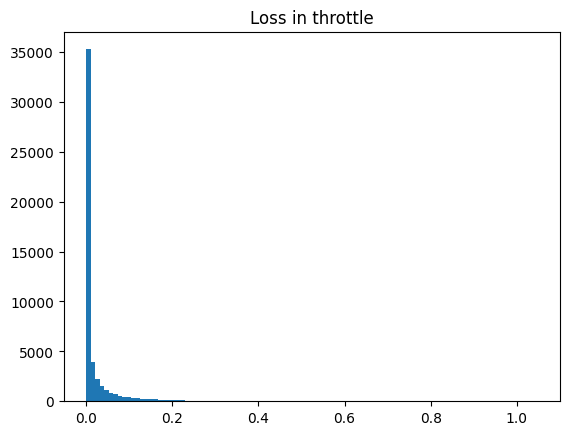

In [38]:
plt.hist(loss_steer, bins=100)
plt.title('Loss in steer')
plt.show()
plt.hist(loss_throttle, bins=100)
plt.title('Loss in throttle')
plt.show()

Load data from all 3 sources to test on

In [13]:
with lzma.open("./data/waymo/trajectories.pkl.xz", "rb") as f:
    waymo_trajectories: list[list[State]] = pickle.load(f)

with lzma.open("./data/nuplan/trajectories.pkl.xz", "rb") as f:
    nuplan_trajectories: list[list[State]] = pickle.load(f)

with lzma.open("./data/nuscene/trajectories.pkl.xz", "rb") as f:
    nuscene_trajectories: list[list[State]] = pickle.load(f)

In [14]:
def gen_idm_data(trajectories: list[list[State]]) -> list[Observation]:
    idm_data: list[Observation] = []
    for states in trajectories:
        for i in range(len(states)-1):
            idm_data.append((states[i], states[i+1]))
    return idm_data

def gen_idm_data_split(trajectories: list[list[State]], split: float) -> tuple[list[Observation], list[Observation]]:
    idm_data = gen_idm_data(trajectories)
    random.shuffle(idm_data)
    n_train = int(len(idm_data)*split)
    return idm_data[:n_train], idm_data[n_train:]

# 90:10 train-validation split
random.seed(0)

waymo_idm_train_data, waymo_idm_validation_data = gen_idm_data_split(waymo_trajectories, 0.9)
nuplan_idm_train_data, nuplan_idm_validation_data = gen_idm_data_split(nuplan_trajectories, 0.9)
nuscene_idm_train_data, nuscene_idm_validation_data = gen_idm_data_split(nuscene_trajectories, 0.9)

In [15]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [16]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none


In [17]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

In [49]:
mm = MetadriveModel().to(device)
mm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

In [31]:
import random
random.seed(41)
idm_test_set = random.sample(nuplan_idm_train_data, 500)

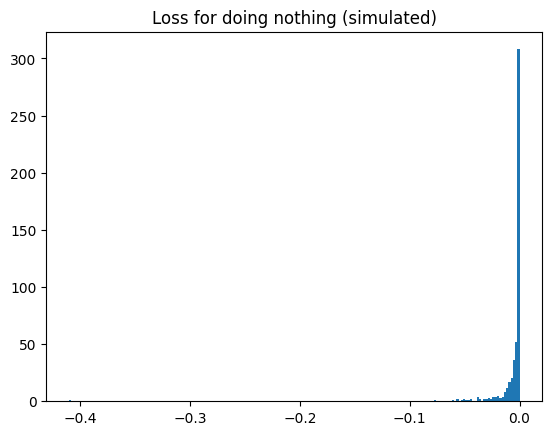

mean -0.0057061224055156385
median -0.000915704019552396


In [32]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

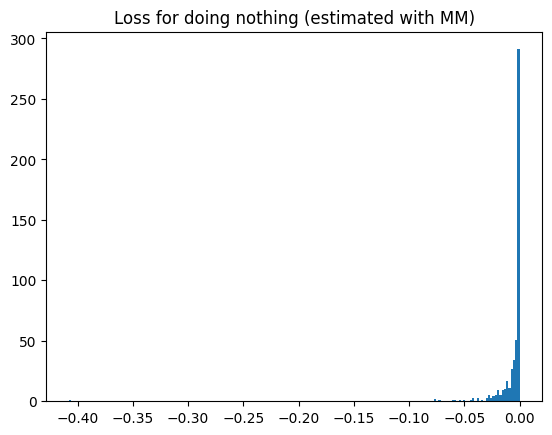

mean -0.00626501896788245
median -0.0009933495578578148


In [50]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

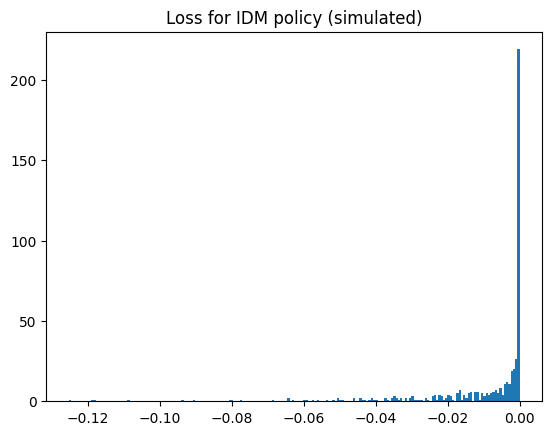

mean -0.009620115084753118
median -0.0014768734804542806


In [51]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

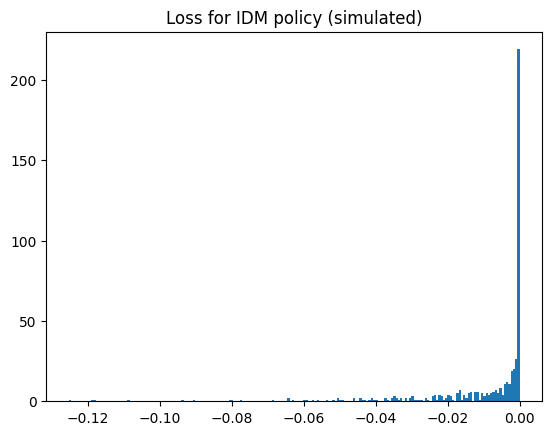

mean -0.009620116565587247
median -0.0014768860658006314


In [52]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

# View Distribution of Actions

In [48]:
obs_batch = waymo_idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.006187609862536192


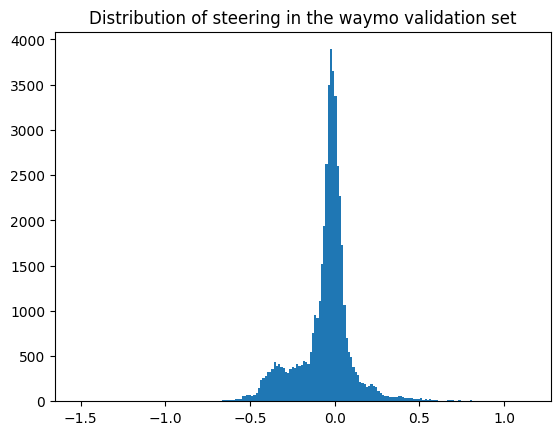

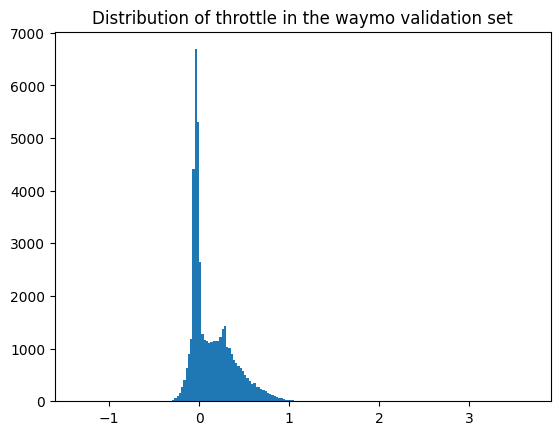

In [40]:
plt.title("Distribution of steering in the waymo validation set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the waymo validation set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

In [41]:
obs_batch = nuplan_idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.0032928474247455597


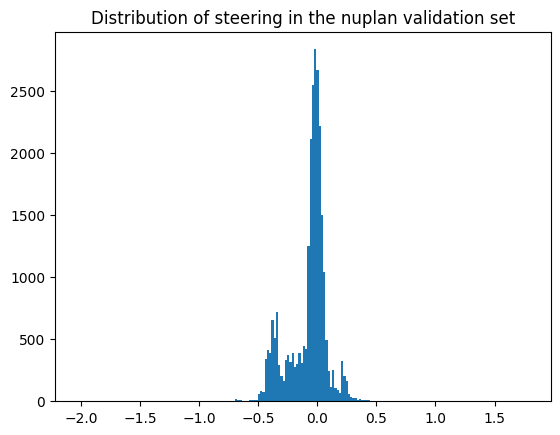

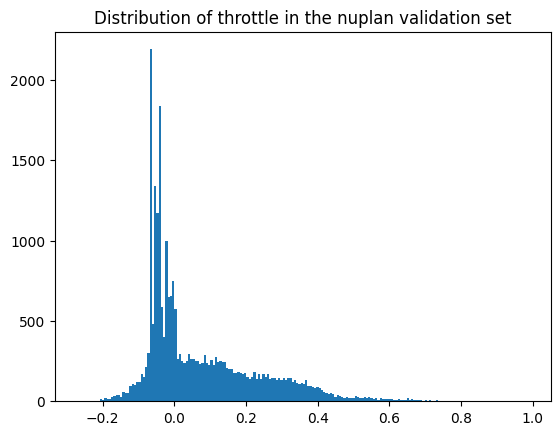

In [42]:
plt.title("Distribution of steering in the nuplan validation set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the nuplan validation set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

In [43]:
obs_batch = nuscene_idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.003666400210931897


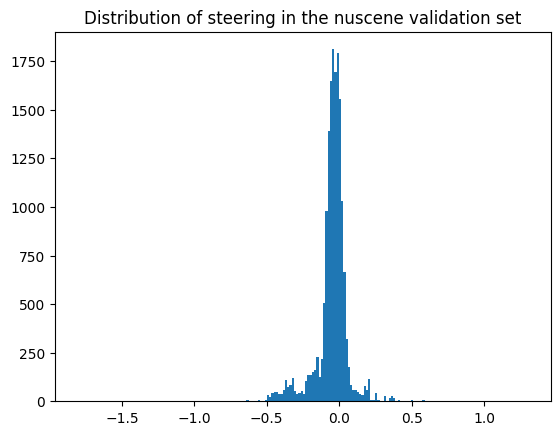

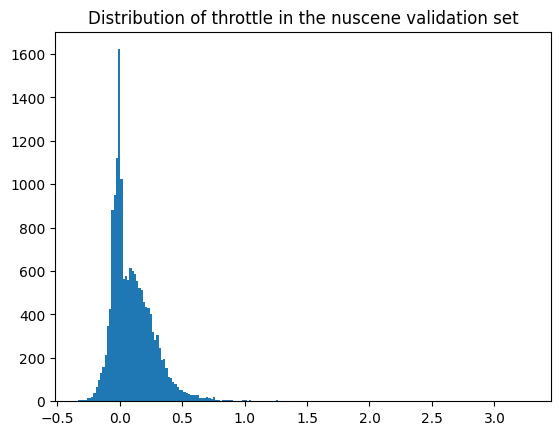

In [44]:
plt.title("Distribution of steering in the nuscene validation set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the nuscene validation set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

In [45]:
obs_batch = [(s0, s1) for s0, _, s1 in mm_validation_data]

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.0018847842002287507


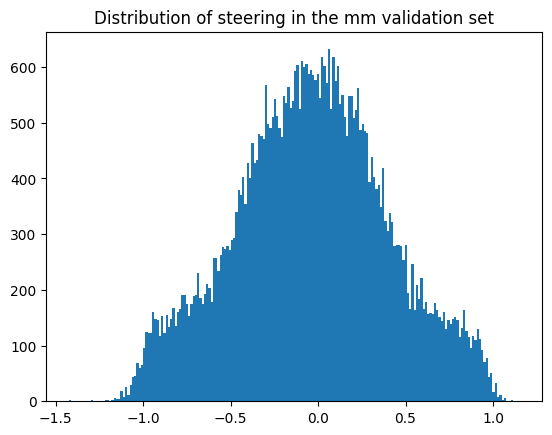

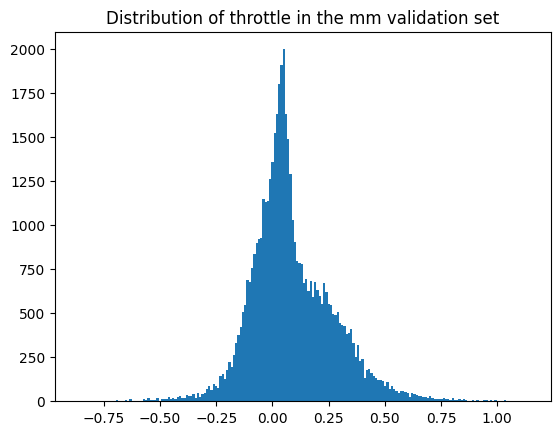

In [46]:
plt.title("Distribution of steering in the mm validation set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the mm validation set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()